In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

In [2]:
##Data generation-----------------------------------
# xi = np.linspace(-5, 5, 100)
# yi = np.linspace(-5, 5, 100)
# X, Y = np.meshgrid(xi, yi)
# ui = np.exp(-(X**2 + Y**2))

In [5]:
# tti = np.zeros(10000)[:,None]
# xxi = X.flatten()[:,None]
# yyi = Y.flatten()[:,None]
# uui = ui.flatten()[:,None]

In [6]:
# x_initial = np.hstack([tti, xxi, yyi])
# u_initial = uui

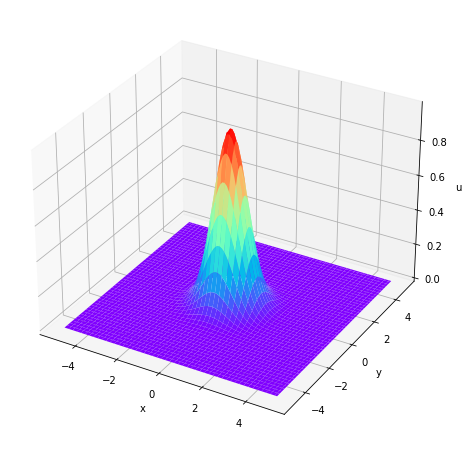

In [7]:
##plotting style-----------------------------------
# fig = plt.figure(figsize = (8, 8))
# ax = fig.add_subplot(111, projection="3d")
# ax.plot_surface(X, Y, ui, cmap = "rainbow")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("u")
# plt.show()

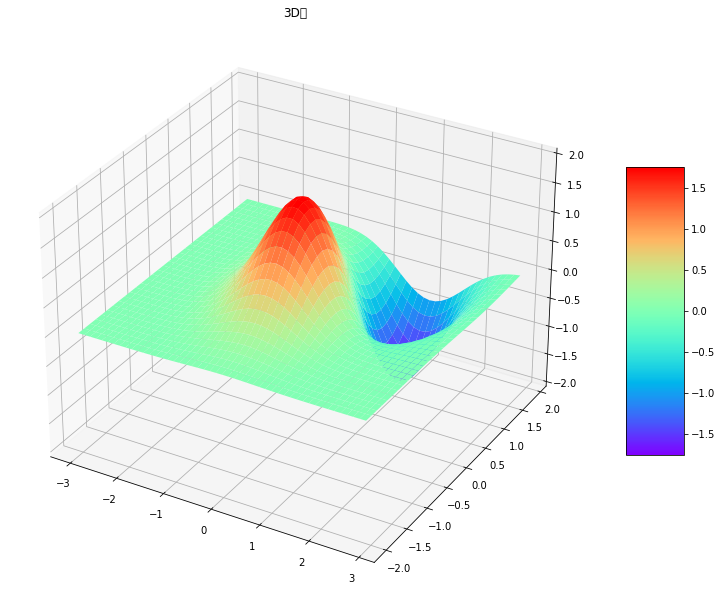

In [8]:
# fig = plt.figure(figsize=(12, 8))
# ax = Axes3D(fig)
#
# delta = 0.125
# # 生成代表X轴数据的列表
# x = np.arange(-3.0, 3.0, delta)
# # 生成代表Y轴数据的列表
# y = np.arange(-2.0, 2.0, delta)
# # 对x、y数据执行网格化
# X, Y = np.meshgrid(x, y)
# Z1 = np.exp(-X**2 - Y**2)
# Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
# # 计算Z轴数据（高度数据）
# Z = (Z1 - Z2) * 2
# # 绘制3D图形
# surf = ax.plot_surface(X, Y, Z,
#                        rstride=1,  # rstride（row）指定行的跨度
#                        cstride=1,  # cstride(column)指定列的跨度
#                        cmap=plt.get_cmap('rainbow'))  # 设置颜色映射
# # 设置Z轴范围
# ax.set_zlim(-2, 2)
# # 设置标题
# plt.title("3D图")
# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()

In [15]:
class PhysicsInformedNN:
    def __init__(self, X_u, u, X_f, layers, lb, ub):
        self.lb = lb
        self.ub = ub
        self.t_u = X_u[:,0:1]
        self.x_u = X_u[:,1:2]
        self.y_u = X_u[:,2:3]
        self.t_f = X_f[:,0:1]
        self.x_f = X_f[:,1:2]
        self.y_f = X_f[:,2:3]
        self.u = u
        self.layers = layers

        self.weights, self.biases = self.initilize_NN(layers)
        self.sess = tf.Session()
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.y_u_tf = tf.placeholder(tf.float32, shape=[None, self.y_u.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.y_f_tf = tf.placeholder(tf.float32, shape=[None, self.y_f.shape[1]])

        self.u_pred = self.net_u(self.t_u_tf, self.x_u_tf, self.y_u_tf)
        self.f_pred = self.net_f(self.t_f_tf, self.x_f_tf, self.y_f_tf)

        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, method = 'L-BFGS-B',
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    #Neural network of output u
    def net_u(self, t, x, y):
        return self.neural_net(tf.concat([t, x, y],1), self.weights, self.biases)

    #Neural network of output f(Automatic differentiation)
    def net_f(self, t, x, y):
        u = self.net_u(t, x, y)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_yy = tf.gradients(u_y, y)[0]
        #>>>>>>>>The method you want to solve::::::::::::::::::::::::::::::::
        return u_t - u_xx - u_yy

    def callback(self, loss):
        print('Loss:', loss)

    def train(self):
        tf_dict = {self.x_u_tf: self.x_u,
                   self.t_u_tf: self.t_u,
                   self.y_u_tf: self.y_u,
                   self.u_tf: self.u,
                   self.x_f_tf: self.x_f,
                   self.t_f_tf: self.t_f,
                   self.y_f_tf: self.y_f}
        self.optimizer.minimize(
                self.sess,
                feed_dict = tf_dict,
                fetches = [self.loss],
                loss_callback = self.callback
        )

    def predict(self, X_star):
        u_star = self.sess.run(self.u_pred, {self.t_u_tf: X_star[:,0:1],
                                           self.x_u_tf: X_star[:,1:2],
                                           self.y_u_tf: X_star[:,2:3]})
        return u_star

In [9]:
np.random.seed(1234)
tf.set_random_seed(1234)

Loss: 0.052433603
Loss: 0.35319978
Loss: 0.12446065
Loss: 0.022521282
Loss: 0.019674888
Loss: 0.01831411
Loss: 0.018184189
Loss: 0.017603256
Loss: 0.017429247
Loss: 0.017380115
Loss: 0.017330324
Loss: 0.017254988
Loss: 0.017127682
Loss: 0.016951086
Loss: 0.016749233
Loss: 0.01670268
Loss: 0.016643306
Loss: 0.016628094
Loss: 0.016572231
Loss: 0.016533252
Loss: 0.016494852
Loss: 0.01643034
Loss: 0.016408397
Loss: 0.016357541
Loss: 0.016288716
Loss: 0.016252277
Loss: 0.016056422
Loss: 0.016007923
Loss: 0.01594307
Loss: 0.015764087
Loss: 0.015601316
Loss: 0.015549119
Loss: 0.015479973
Loss: 0.015324405
Loss: 0.02042912
Loss: 0.015135508
Loss: 0.06178008
Loss: 0.015015181
Loss: 0.0147771165
Loss: 0.014222577
Loss: 0.01401807
Loss: 0.0136569245
Loss: 0.013501991
Loss: 0.013108315
Loss: 0.013167023
Loss: 0.013085087
Loss: 0.013011945
Loss: 0.012868827
Loss: 0.0125548355
Loss: 0.012272941
Loss: 0.011996209
Loss: 0.011904634
Loss: 0.011864292
Loss: 0.011738604
Loss: 0.011449102
Loss: 0.01118375

MovieWriter imagemagick unavailable; using Pillow instead.


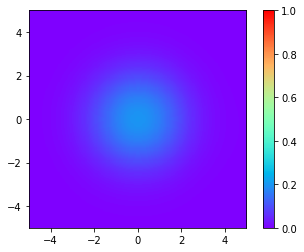

In [16]:
if __name__ == "__main__":

    #>>>>>>>Configuration--------------------------------------------------
    N_u = 1000   #Number of training data for initial conditions and boundary conditions
    N_f = 30000  #Number of collocation points
    x0 = -5      #Starting point of x
    x1 = 5       #End of x
    y0 = -5      #Starting point of y
    y1 = 5       #End of y
    t0 = 0       #Starting point of t
    t1 = 1       #End point of t
    layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1] #Structure of NN
    N = 200      #x,Number of divisions of y
    Nt = 100     #Number of divisions of t
    #Initial conditions------------------------------------------------------
    xi = np.linspace(x0, x1, N)
    yi = np.linspace(y0, y1, N)
    Xi, Yi = np.meshgrid(xi, yi)
    ui = np.exp(-(Xi**2 + Yi**2))

    tti = np.zeros(N*N)[:,None]
    xxi = Xi.flatten()[:,None]
    yyi = Yi.flatten()[:,None]
    uui = ui.flatten()[:,None]

    X_u_train = np.hstack([tti, xxi, yyi])
    u_train = uui
    #Extract as many initial condition data as Nu----------------------------------
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx, :]

    #Generation of 3D coordinate grid points---------------------------------------------
    x = np.linspace(x0, x1, N)
    y = np.linspace(y0, y1, N)
    t = np.linspace(t0, t1, Nt)
    X, Y, T = np.meshgrid(x, y, t)

    tt = T.flatten()[:,None]
    xx = X.flatten()[:,None]
    yy = Y.flatten()[:,None]
    X_star = np.hstack([tt, xx, yy])
    #Generation of collocation points----------------------------------------
    lb = np.array([t0, x0, y0])  #<lower bound>
    ub = np.array([t1, x1, y1])  #<upper bound>
    X_f_train = lb + (ub-lb)*lhs(3, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))
    #Pass data to the PhysicsInformedNN class------------------------------
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub)

    #Execution of operation-------------------------------------------------------
    start_time = time.time()
    model.train()
    run_time = time.time() - start_time
    print('Training time:', run_time)

    #Store the operation result in a variable--------------------------------------------
    u_pred = model.predict(X_star)

    #Plotting style-----------------------------------------------
    ims = []    #gif animation storage box
    fig = plt.figure()
    for j in range(Nt):
        U = []
        for i in range(N*N):
            U = np.append(U, u_pred[Nt*i + j])
        U = U.reshape(N, N)
        im = plt.imshow(U,interpolation='nearest', extent=[x0, x1, y0, y1],
                        cmap='rainbow', vmin=0, vmax=1)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50)
    plt.colorbar()
    ani.save("output.gif", writer="imagemagick")
    plt.show()